<a href="https://colab.research.google.com/github/srushtinandu/ML-Project/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, SpatialDropout1D
from keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

In [ ]:
url = 'https://raw.githubusercontent.com/srushtinandu/NLP-Project/main/data/train.tsv'
df = pd.read_csv(url, sep = '\t')
df.columns=['ID', 'Label', 'Statement', 'subject(s)', 'speaker', 'speaker\'s job', 'state info', 'party affiliation', 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts', 'context']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10239 entries, 0 to 10238
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    10239 non-null  object 
 1   Label                 10239 non-null  object 
 2   Statement             10239 non-null  object 
 3   subject(s)            10237 non-null  object 
 4   speaker               10237 non-null  object 
 5   speaker's job         7342 non-null   object 
 6   state info            8031 non-null   object 
 7   party affiliation     10237 non-null  object 
 8   barely true counts    10237 non-null  float64
 9   false counts          10237 non-null  float64
 10  half true counts      10237 non-null  float64
 11  mostly true counts    10237 non-null  float64
 12  pants on fire counts  10237 non-null  float64
 13  context               10137 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


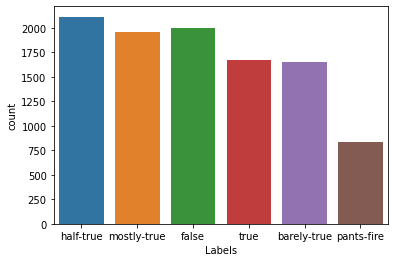

In [ ]:
sns.countplot(x=df.Label)
plt.xlabel('Labels')
plt.show()

In [ ]:
def to_label(label):
  if label == 'mostly-true' or label == 'half-true':
    return 'true'
  elif label == 'pants-fire' or label == 'barely-true':
    return 'false'
  else:
    return label

df['Label'] = df.Label.apply(to_label)

In [ ]:
df = df[df['Statement'].notna()]

In [ ]:
df = df.reset_index(drop=True)
NUMBERS_RE = re.compile('[^0-9]+')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [ ]:
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    result = re.match(r"[0-9]+", text)
    if result != None:
      text = NUMBERS_RE.sub('X', text)

    text = text.replace('X', '')
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df['Statement'] = df['Statement'].apply(clean_text)
df['Statement'] = df['Statement'].str.replace('\d+', '')

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Statement'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 12281 unique tokens.


In [ ]:
X_train = tokenizer.texts_to_sequences(df['Statement'].values)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train.shape)

Shape of data tensor: (10239, 50)


In [ ]:
y_train = pd.get_dummies(df['Label']).values
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (10239, 2)


In [ ]:
url = 'https://raw.githubusercontent.com/srushtinandu/NLP-Project/main/data/valid.tsv'
valid_data = pd.read_csv(url, sep = '\t')
valid_data.columns=['ID', 'Label', 'Statement', 'subject(s)', 'speaker', 'speaker\'s job', 'state info', 'party affiliation', 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts', 'context']
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1283 entries, 0 to 1282
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    1283 non-null   object
 1   Label                 1283 non-null   object
 2   Statement             1283 non-null   object
 3   subject(s)            1283 non-null   object
 4   speaker               1283 non-null   object
 5   speaker's job         938 non-null    object
 6   state info            1004 non-null   object
 7   party affiliation     1283 non-null   object
 8   barely true counts    1283 non-null   int64 
 9   false counts          1283 non-null   int64 
 10  half true counts      1283 non-null   int64 
 11  mostly true counts    1283 non-null   int64 
 12  pants on fire counts  1283 non-null   int64 
 13  context               1271 non-null   object
dtypes: int64(5), object(9)
memory usage: 140.5+ KB


In [ ]:
valid_data = valid_data[valid_data['Statement'].notna()]

In [ ]:
valid_data['Label'] = valid_data.Label.apply(to_label)
valid_data = valid_data.reset_index(drop=True)
valid_data['Statement'] = valid_data['Statement'].apply(clean_text)
valid_data['Statement'] = valid_data['Statement'].str.replace('\d+', '')
tokenizer.fit_on_texts(valid_data['Statement'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13002 unique tokens.


In [ ]:
X_valid = tokenizer.texts_to_sequences(valid_data['Statement'].values)
X_valid = pad_sequences(X_valid, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_valid.shape)

Shape of data tensor: (1283, 50)


In [ ]:
y_valid = pd.get_dummies(valid_data['Label']).values
print('Shape of label tensor:', y_valid.shape)

Shape of label tensor: (1283, 2)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['binary_accuracy'])

epochs = 7
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_valid, y_valid), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/7
320/320 [==============================] - 65s 186ms/step - loss: 0.8647 - binary_accuracy: 0.5265 - val_loss: 0.6929 - val_binary_accuracy: 0.5187
Epoch 2/7
320/320 [==============================] - 60s 189ms/step - loss: 0.6569 - binary_accuracy: 0.6254 - val_loss: 0.7122 - val_binary_accuracy: 0.5269
Epoch 3/7
320/320 [==============================] - 61s 191ms/step - loss: 0.5743 - binary_accuracy: 0.7331 - val_loss: 0.7929 - val_binary_accuracy: 0.5121
Epoch 4/7
320/320 [==============================] - 61s 190ms/step - loss: 0.5033 - binary_accuracy: 0.7717 - val_loss: 1.6794 - val_binary_accuracy: 0.5156


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           1000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 1,125,634
Trainable params: 1,125,634
Non-trainable params: 0
______________________________________________

In [ ]:
url = 'https://raw.githubusercontent.com/srushtinandu/NLP-Project/main/data/test.tsv'
test_data = pd.read_csv(url, sep = '\t')
test_data.columns=['ID', 'Label', 'Statement', 'subject(s)', 'speaker', 'speaker\'s job', 'state info', 'party affiliation', 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts', 'context']

In [ ]:
test_data = test_data[test_data['Statement'].notna()]

In [ ]:
test_data['Label'] = test_data.Label.apply(to_label)
test_data = test_data.reset_index(drop=True)
test_data['Statement'] = test_data['Statement'].apply(clean_text)
test_data['Statement'] = test_data['Statement'].str.replace('\d+', '')
tokenizer.fit_on_texts(test_data['Statement'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13699 unique tokens.


In [ ]:
X_test = tokenizer.texts_to_sequences(test_data['Statement'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)

Shape of data tensor: (1266, 50)


In [ ]:
y_test = pd.get_dummies(test_data['Label']).values
print('Shape of label tensor:', y_test.shape)

Shape of label tensor: (1266, 2)


In [ ]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

40/40 [==============================] - 1s 13ms/step - loss: 1.4731 - binary_accuracy: 0.5340
Test set
  Loss: 1.473
  Accuracy: 0.534


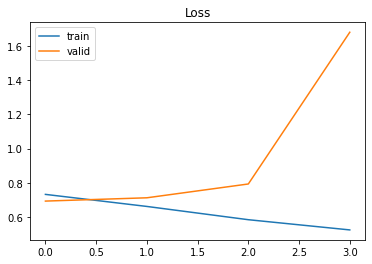

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [ ]:
for key in history.history.keys():
    print(key)

loss
binary_accuracy
val_loss
val_binary_accuracy


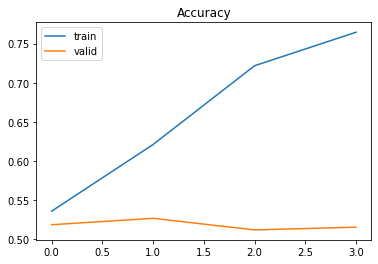

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='valid')
plt.legend()
plt.show();